In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import box
import geopandas as gpd
import numpy as np

from tqdm import tqdm  # Optional: For progress tracking

from shapely import wkt


In [3]:

import unicodedata

# Function to normalize the names
def normalize_municipality_name(name):
    if type(name) == float:
        return name
    else:
        # Normalize the string (remove diacritical marks)
        name_without_diacritics = unicodedata.normalize('NFKD', name).encode('ascii', 'ignore').decode('ascii')
        # Convert to lowercase
        return name_without_diacritics.lower()



In [4]:
mun_gdf = gpd.read_file(r'../../../../../portugal/municipality_data/municipalities-shapefile-2/concelhos.shp')
mun_metadata = pd.read_excel(r'../../../../../portugal/municipality_data/concelhos-metadata.xlsx', dtype={'dicofre' : 'string'})

mun_metadata = mun_metadata[['dicofre','designacao']]

mun_gdf = mun_gdf.merge(mun_metadata, left_on='CCA_2', right_on='dicofre').drop(columns='NAME_2')
mun_gdf = mun_gdf.rename(columns={'designacao': 'NAME_2'})

In [5]:
mun_gdf['concelho'] = mun_gdf['NAME_2'].map(normalize_municipality_name)
mun_gdf = mun_gdf[~mun_gdf['NAME_1'].isin(['Azores', 'Madeira'])]
west, south, east, north = mun_gdf.total_bounds

In [14]:


# Enable tqdm progress for pandas apply if desired (optional)
tqdm.pandas()

def aggregate_to_municipality(df, municipalities_gdf, 
                              grid_resolution=(0.25, 0.25), 
                              time_range=(2013, 2023), 
                              lat_col='latitude', 
                              lon_col='longitude', 
                              time_col='time', 
                              municipality_id_col='concelho'):
    """
    Processes a cleaned DataFrame (from a parquet file) and aggregates its numerical variables 
    to the municipality level using area-weighted aggregation.
    
    The function performs the following steps:
      1. Renames 'lat' or 'lon' columns to 'latitude' and 'longitude' if needed.
      2. Filters the time column to years within time_range (if a time column exists).
      3. Creates a GeoDataFrame from the lat/lon points.
      4. Constructs square polygons centered on each point with the specified grid_resolution.
      5. Reprojects the GeoDataFrame to EPSG:3763.
      6. Uses an overlay with the provided municipalities to select only the grid cells that 
         fall within Portuguese boundaries.
      7. Performs a spatial join so that each grid cell gets assigned its municipality.
      8. Computes the area for each grid cell (vectorized).
      9. For each numeric column (excluding lat, lon, time, geometry, and area),
         computes an area‐weighted value.
     10. Groups the data by municipality (and time, if available) and sums the weighted values.
    
    Parameters:
      df : pd.DataFrame
          Input DataFrame containing the point-level data.
      municipalities_gdf : gpd.GeoDataFrame
          A GeoDataFrame with municipality polygons. This should either be in EPSG:3763 or 
          will be reprojected.
      grid_resolution : tuple (lat_resolution, lon_resolution)
          Resolution of the grid cells (polygons) to construct around each point.
      time_range : tuple (start_year, end_year)
          The inclusive range of years to keep (if a time column exists).
      lat_col, lon_col : str
          Column names for latitude and longitude. If the DataFrame has columns 'lat' or 'lon', 
          they will be renamed accordingly.
      time_col : str
          Column name for the time variable.
      municipality_id_col : str
          Column name in the municipalities GeoDataFrame that identifies the municipality.
    
    Returns:
      aggregated : pd.DataFrame
          A DataFrame aggregated to the municipality level with area‐weighted values.
    """
    # Work on a copy so as not to modify the original DataFrame
    df = df.copy()
    # NEW – keep a record of the meteorological columns before any spatial operations
    orig_numeric_cols = df.select_dtypes(include=[np.number]).columns.difference([lat_col, lon_col])

    municipalities_gdf = municipalities_gdf.copy()
    print("Renaming Columns if needed")
    # Rename lat/lon columns if needed
    if 'lat' in df.columns and lat_col not in df.columns:
        df.rename(columns={'lat': lat_col}, inplace=True)
    if 'lon' in df.columns and lon_col not in df.columns:
        df.rename(columns={'lon': lon_col}, inplace=True)
    print("Filtering the time column if present")
    # if time not in columns rename time
    if 'time' not in df.columns:
        df.rename(columns={'valid_time': 'time'}, inplace=True)
    # Filter the time column if present
    if time_col in df.columns:
        df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
        start_year, end_year = time_range
        df = df[(df[time_col].dt.year >= start_year) & (df[time_col].dt.year <= end_year)]
    print("Creating a GeoDataFrame from the lat/lon points")
    # Create a GeoDataFrame using the lat/lon points
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df[lon_col], df[lat_col]), crs="EPSG:4326")
    
    # Build square polygons for each point. Here we use a list comprehension with tqdm for progress.
    lat_res, lon_res = grid_resolution
    half_lat = lat_res / 2.0
    half_lon = lon_res / 2.0
    polygons = [box(pt.x - half_lon, pt.y - half_lat, pt.x + half_lon, pt.y + half_lat) 
                for pt in tqdm(gdf.geometry, desc="Creating grid polygons")]
    gdf['geometry'] = polygons
    
    # Reproject to target CRS (EPSG:3763)
    gdf = gdf.to_crs("EPSG:3763")
    if municipalities_gdf.crs != "EPSG:3763":
        municipalities_gdf = municipalities_gdf.to_crs("EPSG:3763")
    municipalities_gdf = municipalities_gdf[['NAME_1', 'concelho', 'geometry', 'NAME_2']]
    # # Build a GeoDataFrame of unique grid polygons (using WKT as a unique key)
    # unique_wkts = np.unique(gdf['geometry'].apply(lambda geom: geom.wkt))
    # unique_polygons = [wkt.loads(wkt_str) for wkt_str in unique_wkts]
    # poly_era5 = gpd.GeoDataFrame({'geometry': unique_polygons}, crs="EPSG:3763")
    # #print(unique_polygons)
    # # Find the grid cells that intersect with the municipalities
    # mun_poly_to_be_join = gpd.overlay(municipalities_gdf, poly_era5, how='intersection')
    
    # # Spatial join: assign each grid cell its municipality by checking which municipality polygon it falls within.
    # #joined = gpd.sjoin(mun_poly_to_be_join,gdf, how='inner', predicate='intersects')
    # joined = gpd.sjoin(gdf, mun_poly_to_be_join, how='inner', predicate='intersecna_countsts')

    # REPLACE the whole unique-polygon / overlay / sjoin section with a single intersection
    joined = gpd.overlay(
        gdf,
        municipalities_gdf[[municipality_id_col, "geometry"]],
        how="intersection"
    )
    joined["area"] = joined.geometry.area

    joined.drop(columns=['index_left', 'index_right'], inplace=True, errors='ignore')
    # Compute the area of each grid cell (vectorized)
    joined['area'] = joined.geometry.area
    
    # Grouping columns (municipality identifier and time if available)
    group_cols = [municipality_id_col]
    if time_col in joined.columns:
        group_cols.append(time_col)
    
    # Compute total area per group (vectorized)
    joined['total_area'] = joined.groupby(group_cols)['area'].transform('sum')
    
    # Identify numeric columns to aggregate (exclude key columns)
    exclude_cols = {lat_col, lon_col, time_col, 'geometry', 'area', 'total_area'}
    #numeric_cols = joined.select_dtypes(include=[np.number]).columns.difference(list(exclude_cols) + group_cols)
    # REPLACE the existing numeric_cols definition
    numeric_cols = [c for c in orig_numeric_cols if c in joined.columns]

    # Calculate the area-weighted value for each numeric column
    for col in numeric_cols:
        joined[f'{col}_wtd'] = joined[col] * (joined['area'] / joined['total_area'])
    
    # Group by municipality (and time, if available) and sum the weighted values
    weighted_cols = [f'{col}_wtd' for col in numeric_cols]
    aggregated = joined.groupby(group_cols)[weighted_cols].sum().reset_index()

    return aggregated


In [24]:


def build_coverage_table(df, municipalities_gdf, grid_resolution=(0.25, 0.25),
                         lat_col='latitude', lon_col='longitude', municipality_id_col='concelho'):
    """
    One-off overlay returning the fractional coverage of each grid cell
    (identified by polygon_id) within every municipality.

    Returns
    -------
    coverage_table : pd.DataFrame
        Columns: ['polygon_id', municipality_id_col, 'coverage']
    grid_lookup : pd.DataFrame
        Maps (lat, lon) to polygon_id for later merging.
    """
    # --- in build_coverage_table (immediately after the docstring) ---
    # standardise latitude/longitude column names                           # new
    if 'lat' in df.columns and lat_col not in df.columns:                   # new
        df = df.rename(columns={'lat': lat_col})                            # new
    if 'lon' in df.columns and lon_col not in df.columns:                   # new
        df = df.rename(columns={'lon': lon_col})                            # new

    # --- unique grid centroids ------------------------------------------------
    coords = (df[[lat_col, lon_col]]
              .drop_duplicates()
              .reset_index(drop=True))
    coords['polygon_id'] = np.arange(len(coords), dtype=np.int32)

    # --- square polygons about each centroid ---------------------------------
    lat_res, lon_res = grid_resolution
    half_lat, half_lon = lat_res / 2.0, lon_res / 2.0

    gdf = gpd.GeoDataFrame(
        coords,
        geometry=gpd.points_from_xy(coords[lon_col], coords[lat_col]),
        crs='EPSG:4326'
    )
    gdf['geometry'] = [
        box(pt.x - half_lon, pt.y - half_lat, pt.x + half_lon, pt.y + half_lat)
        for pt in tqdm(gdf.geometry, desc='grid polygons')
    ]
    gdf = gdf.to_crs('EPSG:3763')

    # --- municipalities to target CRS ----------------------------------------
    muni = municipalities_gdf.to_crs('EPSG:3763')[['geometry', municipality_id_col]]

    # --- overlay --------------------------------------------------------------
    inter = gpd.overlay(muni, gdf[['polygon_id', 'geometry']], how='intersection')
    inter['inter_area'] = inter.geometry.area
    cell_area = inter.groupby('polygon_id')['inter_area'].sum().rename('cell_area')
    inter = inter.merge(cell_area, on='polygon_id')
    inter['coverage'] = inter['inter_area'] / inter['cell_area']

    coverage_table = inter[['polygon_id', municipality_id_col, 'coverage']]
    grid_lookup = coords[['polygon_id', lat_col, lon_col]]
    return coverage_table, grid_lookup


def aggregate_with_coverage(df, coverage_table, grid_lookup,
                            time_col='time', municipality_id_col='concelho',
                            lat_col='latitude', lon_col='longitude',
                            freq='M', time_range=(2010, 2022)):
    """
    Area-weights numeric columns using a pre-computed coverage table.

    Parameters
    ----------
    freq : str
        Resampling frequency alias passed to pd.Grouper, e.g. 'D', 'M', 'Y'.

    Returns
    -------
    aggregated : pd.DataFrame
        Weighted sums by municipality and resampling period.
    """
    # --- in aggregate_with_coverage (immediately after the docstring) ---
    # standardise latitude/longitude column names                           # new
    if 'lat' in df.columns and lat_col not in df.columns:                   # new
        df = df.rename(columns={'lat': lat_col})                            # new
    if 'lon' in df.columns and lon_col not in df.columns:                   # new
        df = df.rename(columns={'lon': lon_col})                            # ne
    # --- attach polygon_id ----------------------------------------------------
    df = (df.merge(grid_lookup, on=[lat_col, lon_col], how='left')
            .merge(coverage_table, on='polygon_id', how='left'))

    df = df.dropna(subset=['coverage'])
    df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
    if time_range is not None:
        start, end = time_range
        df = df[df[time_col].between(pd.Timestamp(start), pd.Timestamp(end))]
    # --- identify variables to weight ----------------------------------------
    excl = {lat_col, lon_col, time_col, 'polygon_id', 'coverage'}
    numcols = df.select_dtypes(include=[np.number]).columns.difference(excl)

    # --- area weighting -------------------------------------------------------
    df[numcols] = df[numcols].mul(df['coverage'], axis=0)

    # --- aggregation ----------------------------------------------------------
    grouped = (df
               .groupby([municipality_id_col,
                         pd.Grouper(key=time_col, freq=freq)],
                        sort=False)[numcols]
               .sum()
               .reset_index())
    return grouped


In [27]:
def plot_weighted_variable(agg_df, mun_gdf, latest_time, variable='fwi_wtd', crs="EPSG:4326"):
    """
    Plots the most recent time slice of an aggregated municipality-level variable.

    Parameters:
    - agg_df (pd.DataFrame or gpd.GeoDataFrame): The aggregated DataFrame containing municipality-level data.
    - mun_gdf (gpd.GeoDataFrame): The GeoDataFrame containing municipality boundaries.
    - variable (str): The column name to plot (default is 'fwi_wtd').
    - crs (str): The coordinate reference system for the output GeoDataFrame (default is "EPSG:4326").
    
    Returns:
    - None (displays the plot)
    """
    # Get the latest time value
    
    
    # Filter for the most recent time slice
    test_gdf = agg_df[agg_df['time'] == latest_time]
    
    # Merge with municipality geometries
    test_gdf = gpd.GeoDataFrame(
        test_gdf.merge(mun_gdf, on='concelho', how='left'),
        crs=crs
    )

    # Plot the data
    fig, ax = plt.subplots(figsize=(12, 8))
    test_gdf.plot(column=variable, cmap='viridis', legend=True, ax=ax)
    mun_gdf.plot(ax=ax, facecolor="none", edgecolor='black')

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    # Show the plot
    plt.show()


### Fire
- 0.25 x 0.25

#### FWI

In [29]:
fwi_df = pd.read_parquet(r'/Volumes/Dhruv_External_Disk/climate_data/fire/fire_weather_index_portugal_1979_2021.parquet')


In [30]:
agg_fwi_df = aggregate_to_municipality(fwi_df, mun_gdf, grid_resolution=(0.25, 0.25), time_range=(2006,2022))

Renaming Columns if needed
Filtering the time column if present
Creating a GeoDataFrame from the lat/lon points


Creating grid polygons: 100%|██████████| 56448/56448 [00:00<00:00, 61244.15it/s]


In [28]:
agg_fwi_df.head()

,concelho,time,fwi


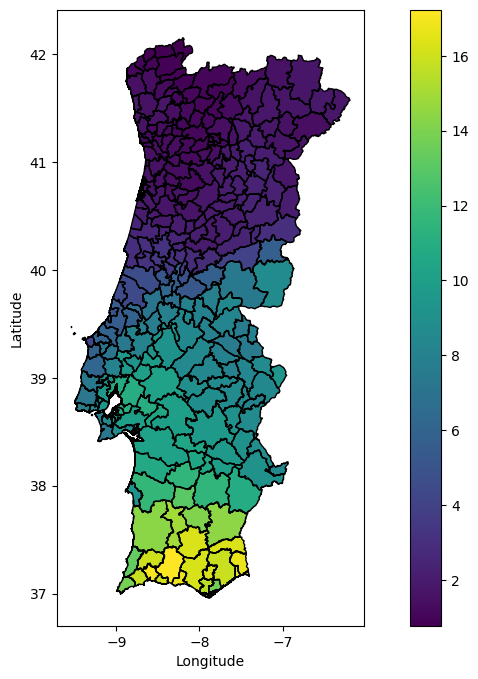

In [10]:
time_1 = agg_fwi_df['time'].iloc[-1]
testgdf = agg_fwi_df[agg_fwi_df['time'] == time_1]
testgdf = gpd.GeoDataFrame(testgdf.merge(mun_gdf, on='concelho', how='left'), crs="EPSG:4326")

fig, ax = plt.subplots(figsize=(12, 8))
testgdf.plot(column = 'fwi_wtd', kind = 'geo', cmap = 'viridis', legend = True, ax = ax)
mun_gdf.plot(ax=ax, facecolor="none", edgecolor='black')  # Adjust colors as needed

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
# Show the plot
plt.show()

#### High Fire Days

In [18]:
high_fire_df = pd.read_parquet(r'/Volumes/Dhruv_External_Disk/climate_data/fire/high_fire_days_portugal_1979_2021.parquet')
high_fire_df = high_fire_df.rename(columns={'fwi': 'high_fire_days'}).copy()


In [19]:
agg_high_fire_df = aggregate_to_municipality(high_fire_df, mun_gdf, grid_resolution=(0.25, 0.25), time_range=(2006,2022))

Renaming Columns if needed
Filtering the time column if present
Creating a GeoDataFrame from the lat/lon points


Creating grid polygons: 100%|██████████| 56448/56448 [00:01<00:00, 53591.16it/s]


In [20]:
agg_high_fire_df

,concelho,time,high_fire_days_wtd
0,abrantes,2006-01-01,0.000000
1,abrantes,2006-02-01,0.000000
2,abrantes,2006-03-01,0.000000
3,abrantes,2006-04-01,0.000000
4,abrantes,2006-05-01,16.379892
...,...,...,...
53371,vouzela,2021-08-01,13.641794
53372,vouzela,2021-09-01,0.573992
53373,vouzela,2021-10-01,0.000000
53374,vouzela,2021-11-01,0.000000


### Precipitation

#### Consecutive Dry Days

In [31]:
cdd_df = pd.read_parquet(r'/Volumes/Dhruv_External_Disk/climate_data/precipitation/dry_days_portugal_1940_2023.parquet')

In [32]:
agg_cdd_df = aggregate_to_municipality(cdd_df, mun_gdf, grid_resolution=(0.25, 0.25), time_range=(2006,2022))

Renaming Columns if needed
Filtering the time column if present
Creating a GeoDataFrame from the lat/lon points


Creating grid polygons: 100%|██████████| 59976/59976 [00:00<00:00, 62856.60it/s]


#### Extreme Precipitation Total

In [33]:
ex_prec_df = pd.read_parquet(r'/Volumes/Dhruv_External_Disk/climate_data/precipitation/extreme_precipitation_portugal_1940_2023.parquet')

In [34]:
agg_ex_prec_df = aggregate_to_municipality(ex_prec_df, mun_gdf, grid_resolution=(0.25, 0.25), time_range=(2006,2022))

Renaming Columns if needed
Filtering the time column if present
Creating a GeoDataFrame from the lat/lon points


Creating grid polygons: 100%|██████████| 59976/59976 [00:01<00:00, 58542.69it/s]


#### Frequency of Extreme Precipitation

In [35]:
freq_ex_prec_df = pd.read_parquet(r'/Volumes/Dhruv_External_Disk/climate_data/precipitation/frequency_of_extreme_precipitation_portugal_1940_2023.parquet')

In [36]:
agg_freq_ex_prec_df = aggregate_to_municipality(freq_ex_prec_df, mun_gdf, grid_resolution=(0.25, 0.25), time_range=(2006,2022))

Renaming Columns if needed
Filtering the time column if present
Creating a GeoDataFrame from the lat/lon points


Creating grid polygons:   9%|▉         | 5473/59976 [00:00<00:00, 54728.36it/s]

Creating grid polygons: 100%|██████████| 59976/59976 [00:01<00:00, 55324.22it/s]


#### Monthly Historical Deviations

In [81]:
tp_hd_df = pd.read_parquet(r'/Volumes/Dhruv_External_Disk/climate_data/precipitation/monthly_tp_hd_portugal_2000_2022.parquet')

In [82]:
agg_tp_hd_df = aggregate_to_municipality(tp_hd_df, mun_gdf, grid_resolution=(0.25, 0.25), time_range=(2006,2022))

Renaming Columns if needed
Filtering the time column if present
Creating a GeoDataFrame from the lat/lon points


Creating grid polygons: 100%|██████████| 119952/119952 [00:01<00:00, 62740.37it/s]


#### Monthly Variability

In [83]:
tp_std_df_mm_day = pd.read_parquet(r'/Volumes/Dhruv_External_Disk/climate_data/precipitation/monthly_tp_std_portugal_2000_2022.parquet')

In [84]:
agg_tp_std_df_mmday = aggregate_to_municipality(tp_std_df_mm_day, mun_gdf, grid_resolution=(0.25, 0.25), time_range=(2006,2022))

Renaming Columns if needed
Filtering the time column if present
Creating a GeoDataFrame from the lat/lon points


Creating grid polygons: 100%|██████████| 59976/59976 [00:01<00:00, 55056.17it/s]


In [85]:
tp_std_df_mm_hour = pd.read_parquet(r'/Volumes/Dhruv_External_Disk/climate_data/precipitation/monthly_tp_std_mmhour_portugal_2000_2022.parquet')

In [86]:
agg_tp_std_df_mmhour = aggregate_to_municipality(tp_std_df_mm_hour, mun_gdf, grid_resolution=(0.25, 0.25), time_range=(2006,2022))

Renaming Columns if needed
Filtering the time column if present
Creating a GeoDataFrame from the lat/lon points


Creating grid polygons:   0%|          | 0/59976 [00:00<?, ?it/s]

Creating grid polygons: 100%|██████████| 59976/59976 [00:00<00:00, 60062.44it/s]


### Temperature

#### Frost Days

In [43]:
frost_df = pd.read_parquet(r'/Volumes/Dhruv_External_Disk/climate_data/temperature/frost_portugal_1940_2023.parquet')

In [44]:
agg_frost_df = aggregate_to_municipality(frost_df, mun_gdf, grid_resolution=(0.25, 0.25), time_range=(2006,2022))

Renaming Columns if needed
Filtering the time column if present
Creating a GeoDataFrame from the lat/lon points


Creating grid polygons: 100%|██████████| 59976/59976 [00:00<00:00, 66136.55it/s]


#### Heatwaves

In [45]:
heatwaves_df = pd.read_parquet(r'/Volumes/Dhruv_External_Disk/climate_data/temperature/heatwaves_portugal_1940_2023.parquet')

In [46]:
agg_heatwaves_df = aggregate_to_municipality(heatwaves_df, mun_gdf, grid_resolution=(0.25, 0.25), time_range=(2006,2022))

Renaming Columns if needed
Filtering the time column if present
Creating a GeoDataFrame from the lat/lon points


Creating grid polygons: 100%|██████████| 59976/59976 [00:00<00:00, 66648.89it/s]


#### Hot Days

In [47]:
hot_days_df = pd.read_parquet(r'/Volumes/Dhruv_External_Disk/climate_data/temperature/hot_days_portugal_1940_2023.parquet')

In [48]:
agg_hot_days_df = aggregate_to_municipality(hot_days_df, mun_gdf, grid_resolution=(0.25, 0.25), time_range=(2006,2022))

Renaming Columns if needed
Filtering the time column if present
Creating a GeoDataFrame from the lat/lon points


Creating grid polygons:   0%|          | 0/59976 [00:00<?, ?it/s]

Creating grid polygons: 100%|██████████| 59976/59976 [00:00<00:00, 63871.92it/s]


#### Tropical Nights

In [49]:
trop_nights_df = pd.read_parquet(r'/Volumes/Dhruv_External_Disk/climate_data/temperature/tropical_nights_portugal_1940_2023.parquet')

In [50]:
agg_trop_nights_df = aggregate_to_municipality(trop_nights_df, mun_gdf, grid_resolution=(0.25, 0.25), time_range=(2006,2022))

Renaming Columns if needed
Filtering the time column if present
Creating a GeoDataFrame from the lat/lon points


Creating grid polygons: 100%|██████████| 59976/59976 [00:00<00:00, 66651.54it/s]


#### High UTCI Days

In [51]:
utci_df = pd.read_parquet(r'/Volumes/Dhruv_External_Disk/climate_data/temperature/utci_portugal_1940_2023.parquet')


In [52]:
agg_utci_df = aggregate_to_municipality(utci_df, mun_gdf, grid_resolution=(0.25, 0.25), time_range=(2006,2022))

Renaming Columns if needed
Filtering the time column if present
Creating a GeoDataFrame from the lat/lon points


Creating grid polygons: 100%|██████████| 59976/59976 [00:00<00:00, 63535.04it/s]


#### Historical Deviations

In [89]:
t2m_hd_df = pd.read_parquet(r'/Volumes/Dhruv_External_Disk/climate_data/temperature/monthly_t2m_hd_portugal_2000_2022.parquet')

In [90]:
agg_t2m_hd_df = aggregate_to_municipality(t2m_hd_df, mun_gdf, grid_resolution=(0.25, 0.25), time_range=(2006,2022))

Renaming Columns if needed
Filtering the time column if present
Creating a GeoDataFrame from the lat/lon points


Creating grid polygons: 100%|██████████| 119952/119952 [00:02<00:00, 57066.74it/s]


#### Variability

In [87]:
t2m_std_df = pd.read_parquet(r'/Volumes/Dhruv_External_Disk/climate_data/temperature/monthly_t2m_std_portugal_2000_2022.parquet')

In [88]:
agg_t2m_std_df = aggregate_to_municipality(t2m_std_df, mun_gdf, grid_resolution=(0.25, 0.25), time_range=(2006,2022))

Renaming Columns if needed
Filtering the time column if present
Creating a GeoDataFrame from the lat/lon points


Creating grid polygons:   0%|          | 0/59976 [00:00<?, ?it/s]

Creating grid polygons: 100%|██████████| 59976/59976 [00:01<00:00, 59198.19it/s]


### Merge Variables

In [91]:
from functools import reduce
data_frames = [agg_fwi_df, agg_high_fire_df, 
               agg_cdd_df, agg_ex_prec_df, agg_freq_ex_prec_df, agg_tp_hd_df, agg_tp_std_df_mmhour,agg_tp_std_df_mmday, 
               agg_heatwaves_df, agg_hot_days_df,agg_frost_df,  agg_trop_nights_df, agg_utci_df, agg_t2m_hd_df, agg_t2m_std_df]
for df in data_frames:
    if 'time' in df.columns:
        df['time'] = pd.to_datetime(df['time'], errors='coerce').dt.to_period('M').dt.to_timestamp()



climate_merged = reduce(lambda left, right: pd.merge(left, right, on=['concelho', 'time'], how='outer'), data_frames)


In [67]:
climate_merged

,concelho,time,fwi_wtd,high_fire_days_wtd,cdd_wtd,extreme_precipitation_mm_wtd,frequency_of_extreme_precipitation_wtd,historical_dev_tp_wtd,historical_tp_wtd,tp_wtd,...,tp_std_wtd,num_heatwaves_wtd,hot_days_wtd,frost_days_wtd,num_tropical_nights_wtd,high_utci_days_wtd,historical_dev_t2m_wtd,historical_t2m_wtd,t2m_wtd,t2m_std_wtd
0,abrantes,2006-01-01,3.060288,0.000000,13.000000,0.000000,0.000000,NaN,NaN,NaN,...,NaN,0.0,0.000000,2.024827,0.0,0.000000,NaN,NaN,NaN,NaN
1,abrantes,2006-02-01,3.349269,0.000000,7.942155,0.000000,0.000000,NaN,NaN,NaN,...,NaN,0.0,0.000000,0.336106,0.0,0.000000,NaN,NaN,NaN,NaN
2,abrantes,2006-03-01,3.311095,0.000000,12.000000,53.215940,2.688721,NaN,NaN,NaN,...,NaN,0.0,0.000000,0.000000,0.0,0.000000,NaN,NaN,NaN,NaN
3,abrantes,2006-04-01,8.096714,0.000000,7.975173,0.000000,0.000000,NaN,NaN,NaN,...,NaN,0.0,0.000000,0.000000,0.0,1.558486,NaN,NaN,NaN,NaN
4,abrantes,2006-05-01,35.935457,16.379892,28.741621,0.000000,0.000000,NaN,NaN,NaN,...,NaN,0.0,7.067520,0.000000,3.0,10.950346,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56707,vouzela,2022-08-01,NaN,NaN,12.960684,0.000000,0.000000,3.930552,4.091546,0.160994,...,0.404607,0.0,9.450770,0.000000,2.0,17.944580,-8.950389,285.973958,294.924347,2.273375
56708,vouzela,2022-09-01,NaN,NaN,13.000000,53.961794,1.426008,-0.010170,4.091546,4.101716,...,8.885051,0.0,0.067802,0.000000,0.0,2.629413,-5.284650,285.973958,291.258609,2.512689
56709,vouzela,2022-10-01,NaN,NaN,11.562532,22.613170,0.506191,-4.346351,4.091546,8.437898,...,13.121395,0.0,0.000000,0.000000,0.0,0.135603,-3.686146,285.973958,289.660104,1.635368
56710,vouzela,2022-11-01,NaN,NaN,3.000000,21.449835,0.493809,-5.374428,4.091546,9.465974,...,11.001632,0.0,0.000000,0.000000,0.0,0.000000,1.603954,285.973958,284.370004,2.252294


### NAN Tests

In [92]:

na_counts = {}
for col in [col for col in climate_merged.columns if col not in ('concelho', 'time')]:
    na_counts_df = (
        climate_merged
        .groupby('concelho')[col]
        .apply(lambda group: group.isna().sum())
        .reset_index()
    )
    na_counts[col] = na_counts_df[col].max()
pd.DataFrame({'var' : na_counts.keys(), 'nan_count': na_counts.values()})

,var,nan_count
0,fwi_wtd,12
1,high_fire_days_wtd,12
2,cdd_wtd,0
3,extreme_precipitation_mm_wtd,0
4,frequency_of_extreme_precipitation_wtd,0
5,tp_hd_wtd,0
6,tp_std_mm_hour_wtd,0
7,tp_std_wtd,0
8,num_heatwaves_wtd,0
9,hot_days_wtd,0


In [93]:
climate_merged.to_excel(r'../../../../../portugal/purchases_paper/datasets/climate_mun.xlsx')